In [31]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import RegexpTokenizer
import regex as re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [32]:
new_df= pd.read_csv("../data/new_df")

In [33]:
sorted_sum = pd.read_csv("../data/sorted_sum_data.csv")

In [34]:
new_df.head()

,Unnamed: 0,patient_id,age,num_visits,avg_time_between_visits,avg_a1c,avg_control_level,num_obs
0,0,72,56,10,99.777778,7.833333,1,6
1,1,254,64,54,20.584906,8.842857,0,7
2,2,255,64,8,146.857143,10.233333,0,2
3,3,304,70,5,54.500000,7.000000,1,1
4,4,384,66,9,105.250000,8.500000,0,4


In [35]:
sorted_sum.dropna(inplace=True)

In [36]:
sorted_sum.isnull().sum()

Unnamed: 0                 0
patient_id                 0
age                        0
visit_date                 0
summary                    0
num_visits                 0
time_between_visits        0
avg_time_between_visits    0
avg_a1c                    0
dtype: int64

In [37]:
new_df["avg_control_level"].value_counts()

0    666
1    433
Name: avg_control_level, dtype: int64

Add all the summary text together for each patient 

In [38]:
df_grouped = sorted_sum.groupby(['patient_id'],as_index=False)['summary'].sum()
print(df_grouped)

      patient_id                                            summary
0             72  followup diabetes, med refillf/u lab results, ...
1            254  Acute viral illnessf/uRm13 Follow upRm11 Follo...
2            255  DM uncontrolled, HTN uncontrolled, access issu...
3            304  HTN, HLD, DM f/u and refill medLetter for medi...
4            384  64F HTN, DM2, R breast caDM, HLD, HTN f/uDM, h...
...          ...                                                ...
1061      243204  Rm 12- NWPT- Establish care, hx HTN, hiccup, s...
1062      243240  APE, DM, Depressionelevated ASCVD- started hig...
1063      243548  establish care, polysubstance abuse, psychiatr...
1064      243642  right ear fullness and hearing loss, new HTN, ...
1065      243644  establish care, new diabetic on lantus and met...

[1066 rows x 2 columns]


Add a column to put all this text in for each patient 

In [39]:
new_df["total_summary"]=""

for x in range(new_df.shape[0]):
    for i in range(len(df_grouped)):
        try:
            if new_df["patient_id"][x]== df_grouped["patient_id"][i]:
                #index of where patient id is that value 
                new_df["total_summary"][x]= df_grouped["summary"][i]
        except:
            continue 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
new_df.drop(columns=["Unnamed: 0"],inplace=True)

In [41]:
new_df.head()

,patient_id,age,num_visits,avg_time_between_visits,avg_a1c,avg_control_level,num_obs,total_summary
0,72,56,10,99.777778,7.833333,1,6,"followup diabetes, med refillf/u lab results, ..."
1,254,64,54,20.584906,8.842857,0,7,Acute viral illnessf/uRm13 Follow upRm11 Follo...
2,255,64,8,146.857143,10.233333,0,2,"DM uncontrolled, HTN uncontrolled, access issu..."
3,304,70,5,54.500000,7.000000,1,1,"HTN, HLD, DM f/u and refill medLetter for medi..."
4,384,66,9,105.250000,8.500000,0,4,"64F HTN, DM2, R breast caDM, HLD, HTN f/uDM, h..."


Add to the set of stopwords, including numbers  

In [68]:
cvec_combined = CountVectorizer(stop_words = ENGLISH_STOP_WORDS.union({
    'and',
    'for',
    'to',
    "12",
    "13",
    "10"
    
}))

Stem the words, although this might be tedious given the type of text we have in the summary for each patient

In [69]:
stemmer = SnowballStemmer('english')

In [70]:
list_2d = [row.split() for row in new_df["total_summary"]]

In [71]:
stems = []
for row in list_2d:
    stems.append([])
    for word in row:
        stems[-1].append(stemmer.stem(word))
stems[:10]

[['followup',
  'diabetes,',
  'med',
  'refillf/u',
  'lab',
  'results,',
  'dm2,',
  'hlddm',
  'and',
  'dyslipidemia',
  'follow-upuncontrol',
  'dmdm',
  '-',
  'hypoglycemia-',
  'dec.',
  'glyburidepoor',
  'control',
  'dm,',
  'osteoarthr',
  'right',
  'thumb',
  'pipdiabet',
  'follow',
  'upf/u',
  'dm2,',
  'hlddm',
  '(a1c',
  '7.1%),',
  'need',
  'ppsv23/pcv13',
  'vaccin'],
 ['acut',
  'viral',
  'illnessf/urm13',
  'follow',
  'uprm11',
  'follow',
  'upuncontrol',
  'dm',
  ',',
  'utidermatitismed',
  'reconciliationrm',
  '13-',
  'low',
  'back',
  'pn,',
  'urinari',
  'urgency,',
  'burning,',
  'vagin',
  'dischargevictoza',
  'teachingmed',
  'reconciliationabd',
  'pain,',
  'vomitingdmdmcellulitis,',
  'dermatitisf/uintertrigouri,',
  'skin',
  'rashsuperfici',
  'phlebitis,',
  'hypertensiondm,',
  'atyp',
  'cp',
  'episode-',
  'history,',
  'leg',
  'edemadm,',
  'le',
  'edemaheadach',
  'x',
  '3-4',
  'days.',
  'see',
  'notehfu',
  'subdural,',
  '

In [72]:
new_df['clean_text'] = pd.Series([" ".join(word) for word in stems])

In [73]:
new_df.head()

,patient_id,age,num_visits,avg_time_between_visits,avg_a1c,avg_control_level,num_obs,total_summary,clean_text
0,72,56,10,99.777778,7.833333,1,6,"followup diabetes, med refillf/u lab results, ...","followup diabetes, med refillf/u lab results, ..."
1,254,64,54,20.584906,8.842857,0,7,Acute viral illnessf/uRm13 Follow upRm11 Follo...,acut viral illnessf/urm13 follow uprm11 follow...
2,255,64,8,146.857143,10.233333,0,2,"DM uncontrolled, HTN uncontrolled, access issu...","dm uncontrolled, htn uncontrolled, access issu..."
3,304,70,5,54.500000,7.000000,1,1,"HTN, HLD, DM f/u and refill medLetter for medi...","htn, hld, dm f/u and refil medlett for medic n..."
4,384,66,9,105.250000,8.500000,0,4,"64F HTN, DM2, R breast caDM, HLD, HTN f/uDM, h...","64f htn, dm2, r breast cadm, hld, htn f/udm, h..."


In [74]:
cvec_combined.fit(new_df['clean_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'10', '12', '13', 'a', 'about', 'above',
                                      'across', 'after', 'afterwards', 'again',
                                      'against', 'all', 'almost', 'alone',
                                      'along', 'already', 'also', 'although',
                                      'always', 'am', 'among', 'amongst',
                                      'amoungst', 'amount', 'an', 'and',
                                      'another', 'any', 'anyhow', 'anyone', ...}),
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [75]:
combined_wordcounts = cvec_combined.transform(new_df['clean_text'])

In [76]:
df_combined = pd.DataFrame(combined_wordcounts.toarray(), columns = cvec_combined.get_feature_names())

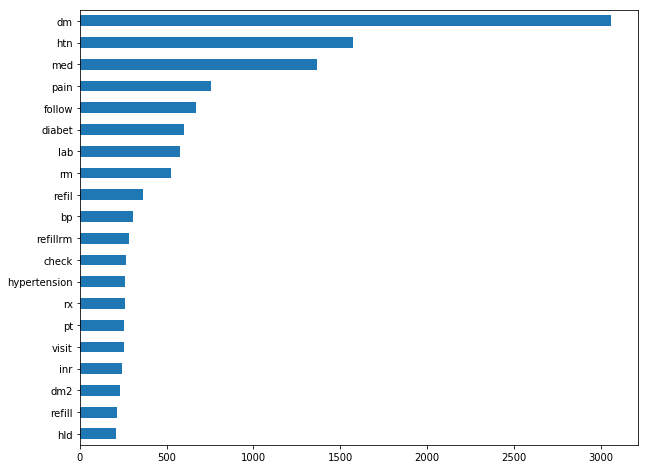

In [77]:
df_combined.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh',figsize=(10,8))
#look at most freuquently used words for patient summaries 

Look at most freuquently used words in patients who were on average controlled 

In [78]:
new_df_controlled= new_df.loc[new_df["avg_control_level"]==1, ["clean_text"]]

In [79]:
new_df_controlled['clean_text'].head()

0     followup diabetes, med refillf/u lab results, ...
3     htn, hld, dm f/u and refil medlett for medic n...
6                                       refil htn medic
9     iddm, htndizziness, dm, htn follow upbp checku...
10    parasthesia, dmdm uncontrol - allerg rhinitisd...
Name: clean_text, dtype: object

In [80]:
cvec_combined.fit(new_df_controlled['clean_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'10', '12', '13', 'a', 'about', 'above',
                                      'across', 'after', 'afterwards', 'again',
                                      'against', 'all', 'almost', 'alone',
                                      'along', 'already', 'also', 'although',
                                      'always', 'am', 'among', 'amongst',
                                      'amoungst', 'amount', 'an', 'and',
                                      'another', 'any', 'anyhow', 'anyone', ...}),
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [81]:
combined_wordcounts_controlled = cvec_combined.transform(new_df_controlled['clean_text'])

In [82]:
df_combined_controlled = pd.DataFrame(combined_wordcounts_controlled.toarray(), columns = cvec_combined.get_feature_names())

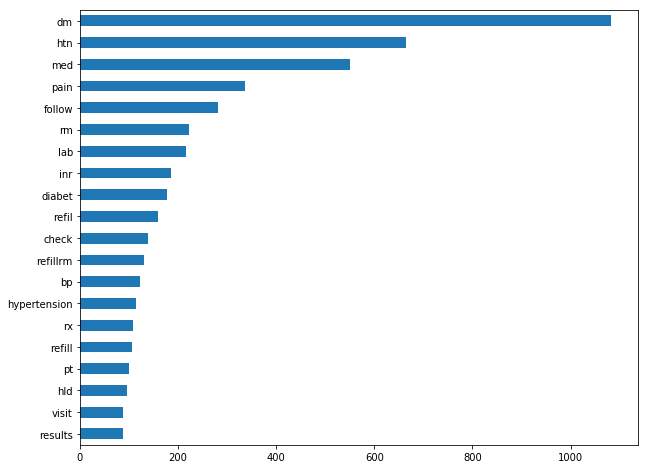

In [83]:
df_combined_controlled.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh',figsize=(10,8))

Look at most frequently used words in uncontrolled group

In [62]:
new_df_uncontrolled= new_df.loc[new_df["avg_control_level"]==0, ["clean_text"]]

In [64]:
cvec_combined.fit(new_df_uncontrolled['clean_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'12', '13', 'a', 'about', 'above',
                                      'across', 'after', 'afterwards', 'again',
                                      'against', 'all', 'almost', 'alone',
                                      'along', 'already', 'also', 'although',
                                      'always', 'am', 'among', 'amongst',
                                      'amoungst', 'amount', 'an', 'and',
                                      'another', 'any', 'anyhow', 'anyone',
                                      'anything', ...}),
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [65]:
combined_wordcounts_uncontrolled = cvec_combined.transform(new_df_uncontrolled['clean_text'])

In [66]:
df_combined_uncontrolled = pd.DataFrame(combined_wordcounts_uncontrolled.toarray(), columns = cvec_combined.get_feature_names())

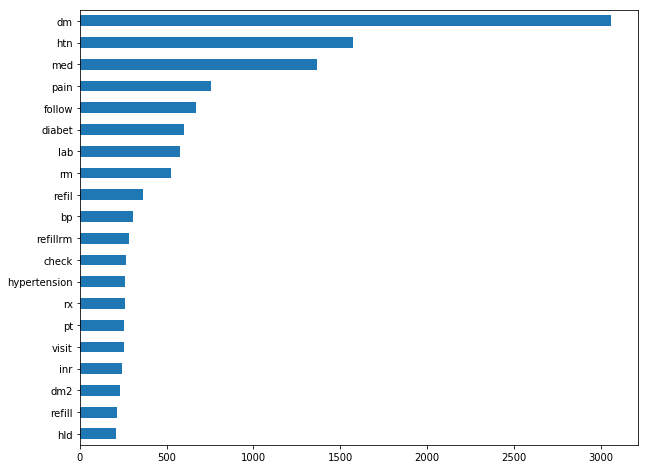

In [84]:
df_combined.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh',figsize=(10,8))

Words like hypertension, diabetes, lab, check and refill appear to be in both controlled and uncontrolled groups. I didn't see any major differences in language used for each type of patient. 

# Modeling

Here, I used both CountVectorizer and TfidVectorizer and MultinomialNB to see which transformer would give the best result, and including stop words and no stop words. 

We used the "clean_text" feature to predict whether or not the patient was 0(uncontrolled) or 1 (controlled). The clean_text feature was the stemmed version of all the summary text summed together from the patient's every visit. 

We train/test/split and created a pipeline and gridsearch using both CountVectorizer and TfidVectorizer with MultinomialNB to see which transformer would give the best result.

In [173]:
X=new_df["clean_text"]
y=new_df["avg_control_level"]

In [174]:
new_df.dropna(inplace=True)

In [175]:
new_df.isnull().sum()

patient_id                 0
age                        0
num_visits                 0
avg_time_between_visits    0
avg_a1c                    0
avg_control_level          0
num_obs                    0
total_summary              0
clean_text                 0
dtype: int64

In [176]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=39,stratify=y)

In [177]:
pipe_cvec= Pipeline([ ("cvec", CountVectorizer(stop_words=ENGLISH_STOP_WORDS.union({
    'and',
    'for',
    'to'
}))),
                        ("mnb", MultinomialNB())
    
])

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS.union({
 'and',
    'for',
    'to'
}))),
     ("mnb", MultinomialNB())
    
])

In [178]:
cvec_params = {
    'cvec__max_features': [100, 500],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words':["english", None]
}

tvec_params = {
    'tvec__max_features': [100, 500],
    'tvec__ngram_range': [(1,1), (1,2)], 
    'tvec__stop_words':["english", None]
}

In [179]:
cvec_gridsearch=GridSearchCV(pipe_cvec,
                            cvec_params,
                            cv=5,
                            verbose=1
                            )

tvec_gridsearch=GridSearchCV(pipe_tvec,
                            tvec_params,
                            cv=5,
                            verbose=1
                            )

In [180]:
cvec_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [181]:
print(cvec_gridsearch.best_score_)

0.6354556803995006


In [182]:
cvec_model = cvec_gridsearch.best_estimator_

In [183]:
cvec_model.score(X_train, y_train)

0.7640449438202247

In [184]:
cvec_model.score(X_test, y_test)

0.602996254681648

In [185]:
tvec_gridsearch.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    4.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [186]:
print(tvec_gridsearch.best_score_)

0.6354556803995006


In [187]:
tvec_model = tvec_gridsearch.best_estimator_

In [188]:
tvec_model

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=500,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('mnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [189]:
tvec_model.score(X_train, y_train)

0.731585518102372

In [190]:
tvec_model.score(X_test, y_test)

0.6217228464419475

In [191]:
print(f' Predicted values: {tvec_gridsearch.predict(X_train)}')

 Predicted values: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1
 0 0 0

In [192]:
pred=tvec_gridsearch.predict(X_test)

In [193]:
cm = confusion_matrix(y_test, pred)

In [194]:
pd.DataFrame(data = cm, columns = ['Predict Postitive', 'Predict Negative'],
             index = ['Actual Positive', 'Actual Negative'])

,Predict Postitive,Predict Negative
Actual Positive,147,13
Actual Negative,88,19


Modelling using NLP still doesn't perform that much better than our baseline score